<a href="https://colab.research.google.com/github/noamZigler/part-2--Technical-Analysis/blob/main/part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [185]:
! pip install ccxt pandas
import ccxt
import pandas as pd
import requests
import time
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum

In [186]:

def make_api_call(base_url, endpoint="", method="GET", **kwargs):
    # Construct the full URL
    full_url = f'{base_url}{endpoint}'

    # Make the API call
    response = requests.request(method=method, url=full_url, **kwargs)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        return response
    else:
        # If the request was not successful, raise an exception with the error message
        raise Exception(f'API request failed with status code {response.status_code}: {response.text}')

In [187]:

exchange = ccxt.binanceus()  # Data only from binanceUS
symbol = "BTC/USDT"
Interval = "30m"
start = int(datetime.datetime(2023, 1, 1).timestamp() * 1000)
end = int(datetime.datetime(2024, 1, 1).timestamp() * 1000)
ohlcv_data = []
while start < end:
    data = exchange.fetch_ohlcv(symbol, Interval, since=start,limit=1000)
    if not data:
        break
    ohlcv_data.extend(data)
    start = data[-1][0] + 1
ohlcv_df = pd.DataFrame(ohlcv_data, columns=["time", "open", "high", "low", "close", "volume"])
ohlcv_df["time"] = pd.to_datetime(ohlcv_df["time"], unit="ms")
ohlcv_df=ohlcv_df.head(17507)


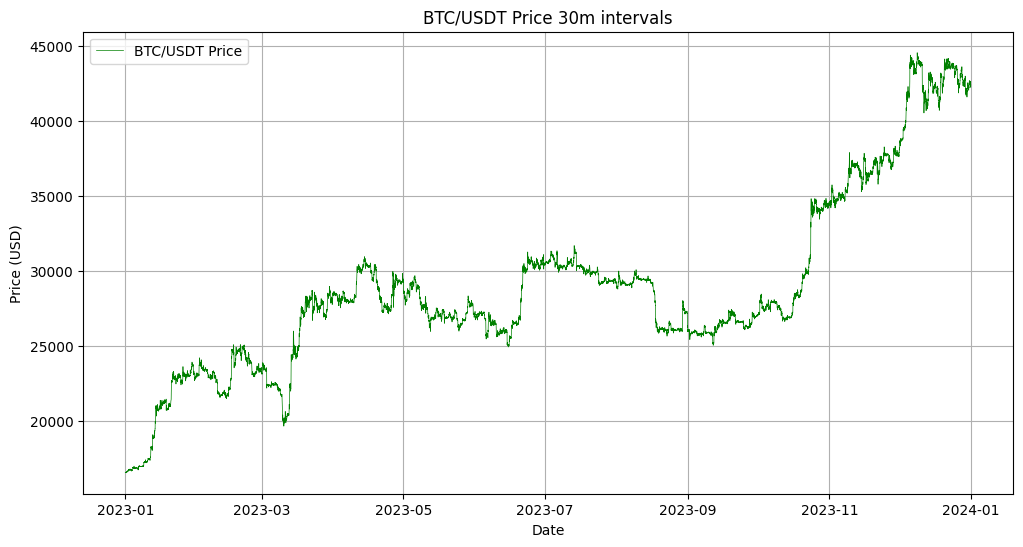

In [188]:
plt.figure(figsize=(12, 6))
plt.plot(ohlcv_df["time"], ohlcv_df["close"], label="BTC/USDT Price", color="green", linewidth=0.5)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("BTC/USDT Price 30m intervals")
plt.legend()
plt.grid()
plt.show()

In [189]:
#נספח א
def TR(high, low, prev_close):
  return np.maximum(high, prev_close) - np.minimum(low, prev_close)

def ATR(tr, atr_length):
  atr = np.zeros(len(tr))
  atr[:atr_length] = np.mean(tr[:atr_length])
  for i in range (atr_length, len(tr)):
    atr[i] = (atr[i - 1] * (atr_length - 1) + tr[i]) / atr_length
  return atr

def crossover(a:pd.Series, b:pd.Series)->pd.Series:
    prev_a = a.shift(1)
    prev_b = b.shift(1)
    return (a > b) & (prev_a < prev_b)


def UTBot(data,atr_length, key_value=2 ):
  data['prev_close'] = data['close'].shift(1).bfill()
  tr = TR(data['high'], data['low'], data['prev_close'])
  atr = ATR(tr, atr_length)
  loss_threshold = key_value * atr
  trailing_stop = pd.Series(np.zeros(len(data)), index=data.index)
  for i in range(1, len(data)):
        if data['close'][i] > trailing_stop[i - 1] and data['close'][i - 1] > trailing_stop[i - 1]:
            trailing_stop[i] = max(trailing_stop[i - 1], data['close'][i] - loss_threshold[i])
        elif data['close'][i] < trailing_stop[i - 1] and data['close'][i - 1] < trailing_stop[i - 1]:
            trailing_stop[i] = min(trailing_stop[i - 1], data['close'][i] + loss_threshold[i])
        elif data['close'][i] > trailing_stop[i - 1]:
            trailing_stop[i] = data['close'][i] - loss_threshold[i]
        else:
            trailing_stop[i] = data['close'][i] + loss_threshold[i]
  above = crossover(data['close'], trailing_stop)
  below = crossover(trailing_stop, data['close'])
  buy_signals = above.astype(int)
  sell_signals = below.astype(int)
  return buy_signals, sell_signals, trailing_stop

#נספח ב
def ema(series, length):
    return series.ewm(span=length, adjust=False).mean()

def MacdDiff(close, fast_length, slow_length) :
  fast_ema = ema(close, fast_length)
  slow_ema = ema(close, slow_length)
  return fast_ema - slow_ema

def SmoothSrs(srs, smoothing_f) :
  smoothed_srs = np.zeros(len(srs))
  smoothed_srs[0] = srs [ 0 ]
  for i in range(1, len(srs)):
    if np.isnan(smoothed_srs[i - 1]):
            smoothed_srs[i] = srs[i]
    else :
      smoothed_srs[i]  =smoothed_srs[i-1] + smoothing_f * (srs[i] - smoothed_srs[i-1])
  return smoothed_srs

def NormalizeSmoothSrs(series, window_length, smoothing_f):
    if isinstance(series, np.ndarray):
        series = pd.Series(series)
    lower_percentile = 5
    upper_percentile = 95
    #Normalizing the data
    lowest = series.rolling(window=window_length, min_periods=1).quantile(lower_percentile / 100)
    highest_range = series.rolling(window=window_length, min_periods=1).quantile(upper_percentile / 100)
    normalized_series = np.where(highest_range > lowest, (series - lowest) / (highest_range - lowest) * 100, np.nan)
    normalized_series = pd.Series(normalized_series).ffill().values
    smoothed_series = SmoothSrs(normalized_series, smoothing_f)
    return smoothed_series

def STC(close, stc_length=80, fast_length=27, slow_length=50, smoothing_factor=0.5):
    macd_diff = MacdDiff(close, fast_length, slow_length)
    normalized_macd = NormalizeSmoothSrs(macd_diff, stc_length, smoothing_factor)
    final_stc = NormalizeSmoothSrs(normalized_macd, stc_length, smoothing_factor)
    return final_stc

In [190]:
class StrategySignal(Enum):
    ENTER_LONG = 2
    ENTER_SHORT = 1
    DO_NOTHING = 0
    CLOSE_SHORT = -1
    CLOSE_LONG = -2

def Strategy(data: pd.DataFrame,STC_low=25,STC_high=75)-> pd.DataFrame:
    '''
    data is an OHLCV table
    STC_low & STC_high are the STC range
    '''
    #init the df
    last_buy_pos=0
    last_sell_pos=0
    data = data.copy()
    data['strategy_signal'] = StrategySignal.DO_NOTHING
    data['Stop_loss_B'] = np.nan
    data['Take_profit_B'] = np.nan
    data['Stop_loss_S'] = np.nan
    data['Take_profit_S'] = np.nan
    data['Long_pos_open']=False
    data['Short_pos_open']=False
    data['STC']=STC(data['close'], smoothing_factor=0.5)
    data['UT_bot_S_buy'], data['UT_bot_S_sell'],data['UT_bot_S_trailing_stop']= UTBot(data, atr_length=1, key_value=2 )
    data['UT_bot_L_buy'], data['UT_bot_L_sell'],data['UT_bot_L_trailing_stop'] = UTBot(data, atr_length=300, key_value=2 )

    for i in range(1,len(data)):

      data.loc[data.index[i], 'Stop_loss_B'] = data['low'].iloc[i - 1]
      data.loc[data.index[i], 'Take_profit_B'] = data['close'].iloc[i] + 2 * np.abs(data['close'].iloc[i] - data['Stop_loss_B'].iloc[i])
      data.loc[data.index[i], 'Stop_loss_S'] = data['high'].iloc[i - 1]
      data.loc[data.index[i], 'Take_profit_S'] = data['close'].iloc[i] - 2 * np.abs(data['close'].iloc[i] - data['Stop_loss_S'].iloc[i])

      #check if we need to close previous positions
      for j in range(max(0,i-1200),i+1):
        if data['Long_pos_open'].iloc[j] and (data['close'].iloc[i]>=data['Take_profit_B'].iloc[j] or data['close'].iloc[i]<=data['Stop_loss_B'].iloc[j]):
          data.loc[data.index[i], 'strategy_signal'] = StrategySignal.CLOSE_LONG
          data.loc[data.index[j], 'Long_pos_open'] = False
          last_buy_pos=j

        if data['Short_pos_open'].iloc[j] and (data['close'].iloc[i]<=data['Take_profit_S'].iloc[j] or data['close'].iloc[i]>=data['Stop_loss_S'].iloc[j]):
          data.loc[data.index[i], 'strategy_signal'] = StrategySignal.CLOSE_SHORT
          data.loc[data.index[j], 'Short_pos_open'] = False
          last_sell_pos=j

      #check if we need to open new position
      if data['UT_bot_S_buy'].iloc[i]  and data['UT_bot_L_buy'].iloc[i] and data['STC'].iloc[i]<STC_low and data['STC'].iloc[i-1]<data['STC'].iloc[i] :
          data.loc[data.index[i], 'strategy_signal'] = StrategySignal.ENTER_LONG
          data.loc[data.index[i], 'Long_pos_open'] = True
      elif data['UT_bot_S_sell'].iloc[i]  and data['UT_bot_L_sell'].iloc[i] and data['STC'].iloc[i]>STC_high and data['STC'].iloc[i-1]>data['STC'].iloc[i]:
          data.loc[data.index[i], 'strategy_signal'] = StrategySignal.ENTER_SHORT
          data.loc[data.index[i], 'Short_pos_open'] = True
    return data



In [191]:
strategy_test_df=Strategy(ohlcv_df)
#This line supposed to take 5-6 minutes to run

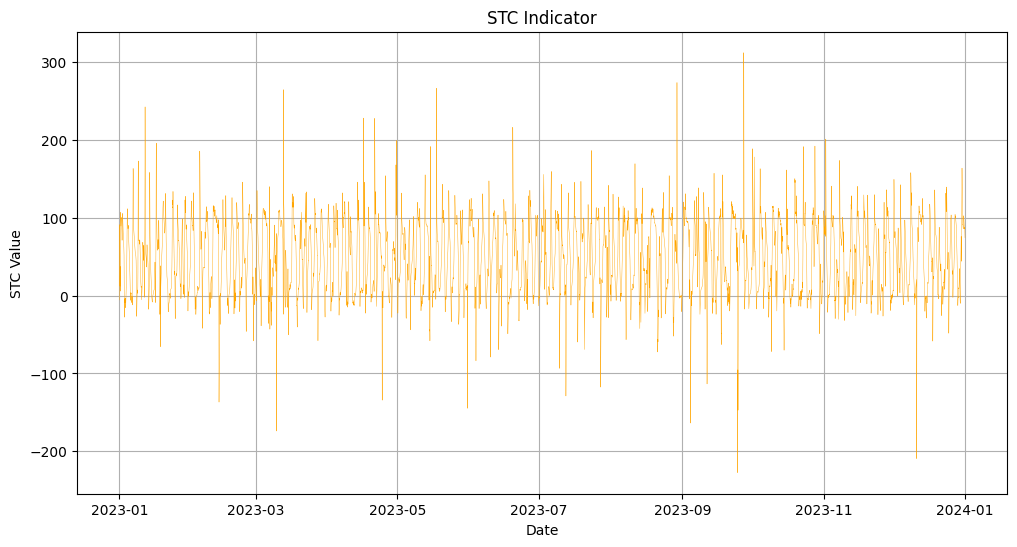

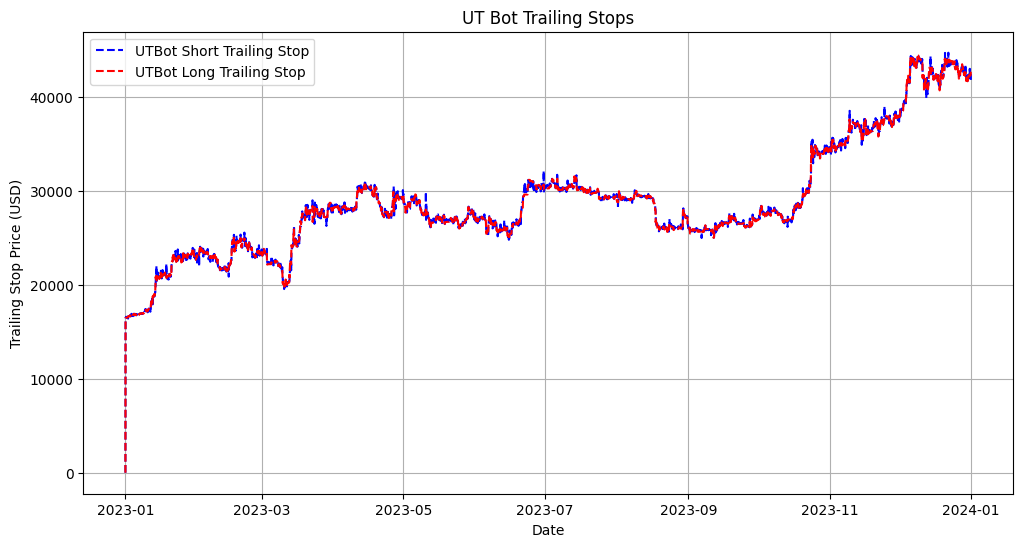

In [192]:

plt.figure(figsize=(12, 6))
plt.plot(strategy_test_df['time'], strategy_test_df['STC'], color="orange", linewidth=0.3)
plt.xlabel("Date")
plt.ylabel("STC Value")
plt.title("STC Indicator")
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(strategy_test_df['time'], strategy_test_df['UT_bot_S_trailing_stop'], label="UTBot Short Trailing Stop", color="blue", linestyle='--')
plt.plot(strategy_test_df['time'], strategy_test_df['UT_bot_L_trailing_stop'], label="UTBot Long Trailing Stop", color="red", linestyle='--')
plt.xlabel("Date")
plt.ylabel("Trailing Stop Price (USD)")
plt.title("UT Bot Trailing Stops")
plt.legend()
plt.grid(True)
plt.show()

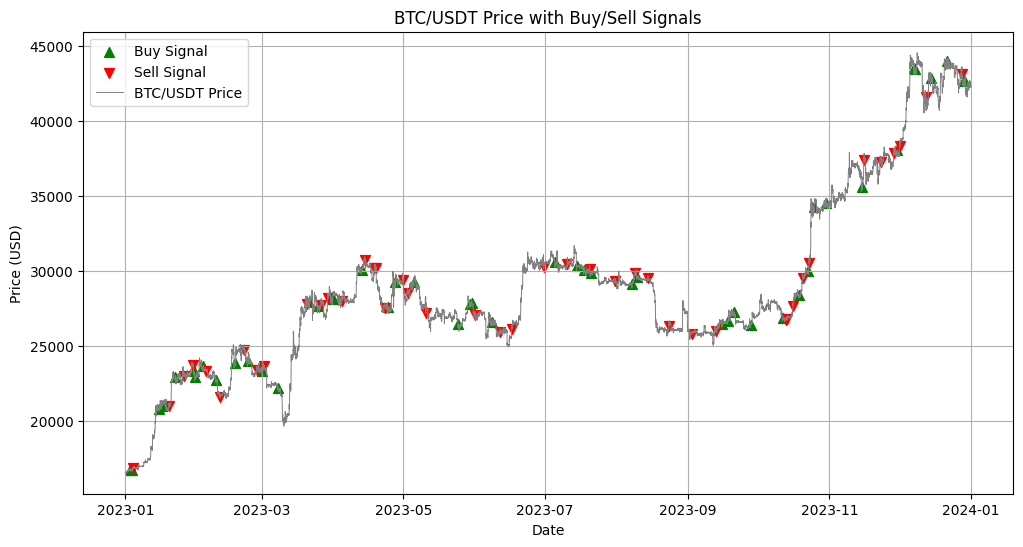

In [193]:
plt.figure(figsize=(12, 6))
buy_signals = strategy_test_df[strategy_test_df['strategy_signal'] == StrategySignal.ENTER_LONG]
plt.scatter(buy_signals['time'], buy_signals['close'], marker='^', color='green', label='Buy Signal', s=50)
sell_signals = strategy_test_df[strategy_test_df['strategy_signal'] == StrategySignal.ENTER_SHORT]
plt.scatter(sell_signals['time'], sell_signals['close'], marker='v', color='red', label='Sell Signal', s=50)
plt.plot(ohlcv_df["time"], ohlcv_df["close"], label="BTC/USDT Price", color="grey", linewidth=0.7)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("BTC/USDT Price with Buy/Sell Signals")
plt.legend()
plt.grid()
plt.show()

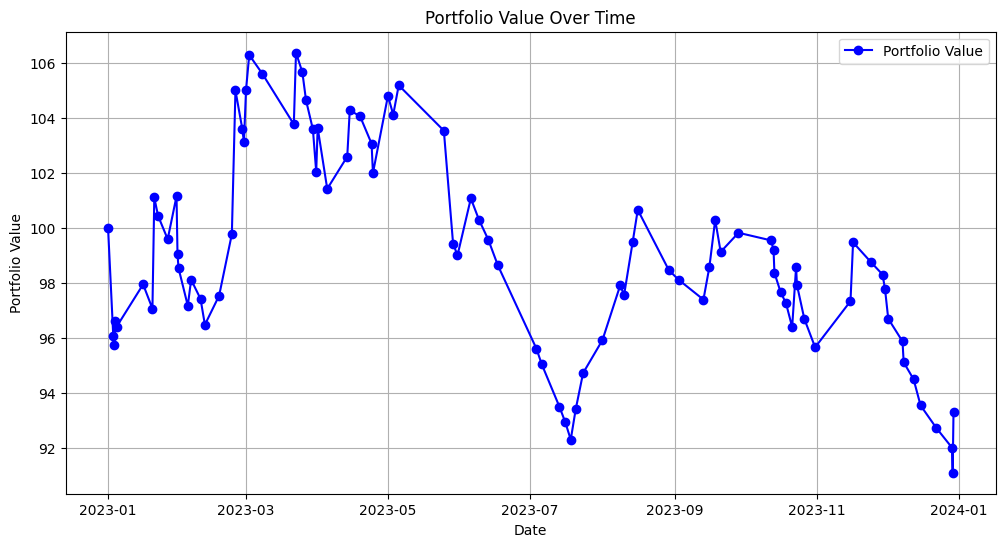

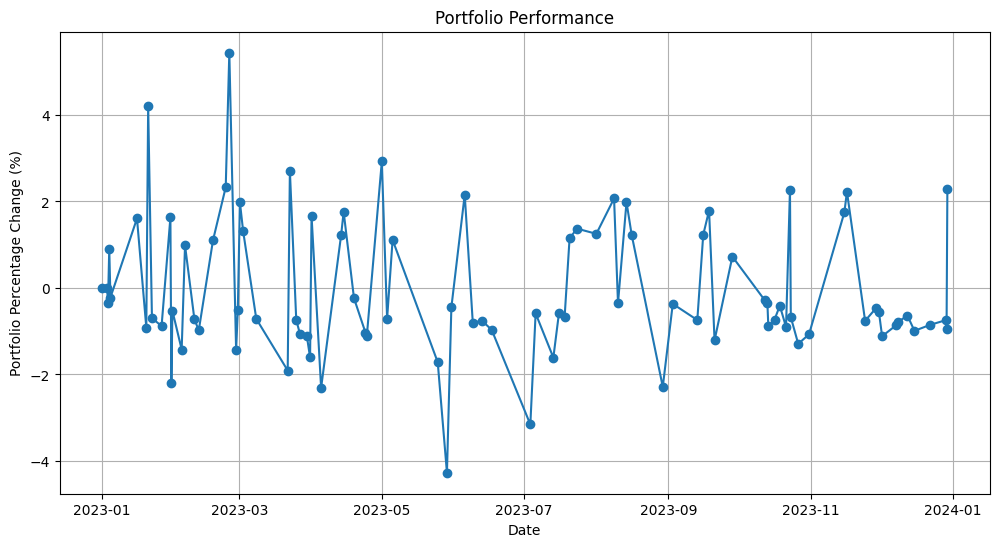

In [194]:
#Total change in the portfolio
#filter the relevant data
filtered_df = strategy_test_df[strategy_test_df['strategy_signal'] != StrategySignal.DO_NOTHING]
portfolio_value = 100.0
pct_change = []
times = []
buy_price = None
short_price = None
for i in range(len(filtered_df)):
    signal = filtered_df['strategy_signal'].iloc[i]
    price = filtered_df['close'].iloc[i]
    current_time = filtered_df['time'].iloc[i]

    if signal == StrategySignal.ENTER_LONG:
        buy_price = price

    elif signal == StrategySignal.CLOSE_LONG:#calculate the precent change
        if buy_price is not None:
            pct_change.append(((price - buy_price) / buy_price) * 100)
            times.append(current_time)
            portfolio_value *= (1 + pct_change[-1] / 100)
            buy_price = None

    elif signal == StrategySignal.ENTER_SHORT:
        short_price = price

    elif signal == StrategySignal.CLOSE_SHORT:#calculate the precent change
        if short_price is not None:
            pct_change.append(((short_price - price) / short_price) * 100)
            times.append(current_time)
            portfolio_value *= (1 + pct_change[-1] / 100)
            short_price = None

#Calculate the precentile changes
pct_change_df = pd.DataFrame({'time': times, 'pct_change': pct_change})
pct_change_df['cumulative_pct_change'] = (pct_change_df['pct_change'] / 100).cumsum() * 100
pct_change_df['portfolio_value'] = portfolio_value * (1 + pct_change_df['cumulative_pct_change'] / 100)
initial_row = pd.DataFrame({'time': [filtered_df['time'].iloc[0]], 'pct_change': [0], 'cumulative_pct_change': [0], 'portfolio_value': [portfolio_value]})
pct_change_df = pd.concat([initial_row, pct_change_df], ignore_index=True)
initial_time = datetime.datetime(2023, 1, 1, 0, 0, 0)
pct_change_df = pd.concat([pd.DataFrame({'time': [initial_time], 'pct_change': [0], 'cumulative_pct_change': [0], 'portfolio_value': [100]}), pct_change_df], ignore_index=True)
pct_change_df = pct_change_df.sort_values(by=['time'])
last_val=pct_change_df['portfolio_value'].tail(1).values[0]
#plotting
plt.figure(figsize=(12, 6))
plt.plot(pct_change_df['time'], pct_change_df['portfolio_value'], marker='o', linestyle='-', label='Portfolio Value', color='blue')
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.grid(True)
plt.legend()
plt.show()

pct_change_df1 = pd.DataFrame({'time': times, 'pct_change': pct_change})
plt.figure(figsize=(12, 6))
plt.plot(pct_change_df['time'], pct_change_df['pct_change'], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Portfolio Percentage Change (%)")
plt.title("Portfolio Performance")
plt.grid(True)
plt.show()


In [195]:
#Statistics
long_trade_returns = []
short_trade_returns = []
open_long_trades = []
open_short_trades = []
for i in range(len(filtered_df)):
    signal = filtered_df['strategy_signal'].iloc[i]
    price = filtered_df['close'].iloc[i]
    if signal == StrategySignal.ENTER_LONG:
        open_long_trades.append((price, i))

    elif signal == StrategySignal.CLOSE_LONG and open_long_trades:
        buy_price, buy_index = open_long_trades.pop(0)
        long_trade_returns.append(((price - buy_price) / buy_price) * 100)

    elif signal == StrategySignal.ENTER_SHORT:
        open_short_trades.append((price, i))

    elif signal == StrategySignal.CLOSE_SHORT and open_short_trades:
        short_price, short_index = open_short_trades.pop(0)
        short_trade_returns.append(((short_price - price) / short_price) * 100)

#Averages
avg_profit_long = pd.Series(long_trade_returns).mean()
avg_profit_short = pd.Series(short_trade_returns).mean()
#Totals
total_long_trades = len(long_trade_returns)
total_short_trades = len(short_trade_returns)
total_deals = total_long_trades + total_short_trades
all_returns = long_trade_returns + short_trade_returns

last_val=pct_change_df['portfolio_value'].tail(1).values[0]

accumulative_pct_change = last_val-100
avg_change_per_deal = accumulative_pct_change / total_deals

print(f"Average Profit for Long: {avg_profit_long:.2f}%")
print(f"Average Profit for Short: {avg_profit_short:.2f}%")
print(f"Total Number of Long Trades: {total_long_trades}")
print(f"Total Number of Short Trades: {total_short_trades}")
print(f"Total Number of Deals: {total_deals}")
print(f"Accumulative Percentage Change: {accumulative_pct_change:.2f}%")
print(f"Average Change per Deal: {avg_change_per_deal:.2f}%")

Average Profit for Long: 0.94%
Average Profit for Short: -0.10%
Total Number of Long Trades: 48
Total Number of Short Trades: 43
Total Number of Deals: 91
Accumulative Percentage Change: -6.70%
Average Change per Deal: -0.07%
